In [40]:
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error




In [41]:
#ex 1 - loading the dataset (it's only 1 column)

df = pd.read_csv('bandwidth.csv')


#the bandwidth usage started on the 1st of january of 2019
# namdwidth is measured in Mbps (megabits per second) which equals 106 bps

start_date = '2019-1-1'
end_date = pd.to_datetime(start_date) + pd.DateOffset(hours=len(df) - 1)
df['time'] = pd.date_range(start=start_date, end=end_date, freq='H')

df.set_index('time', inplace=True)
print(df)

                     hourly_bandwidth
time                                 
2019-01-01 00:00:00       1000.496714
2019-01-01 01:00:00       1000.969408
2019-01-01 02:00:00       1002.046019
2019-01-01 03:00:00       1004.702118
2019-01-01 04:00:00       1007.447816
...                               ...
2020-02-21 11:00:00        740.546059
2020-02-21 12:00:00        738.906228
2020-02-21 13:00:00        736.057995
2020-02-21 14:00:00        733.559640
2020-02-21 15:00:00        732.190049

[10000 rows x 1 columns]


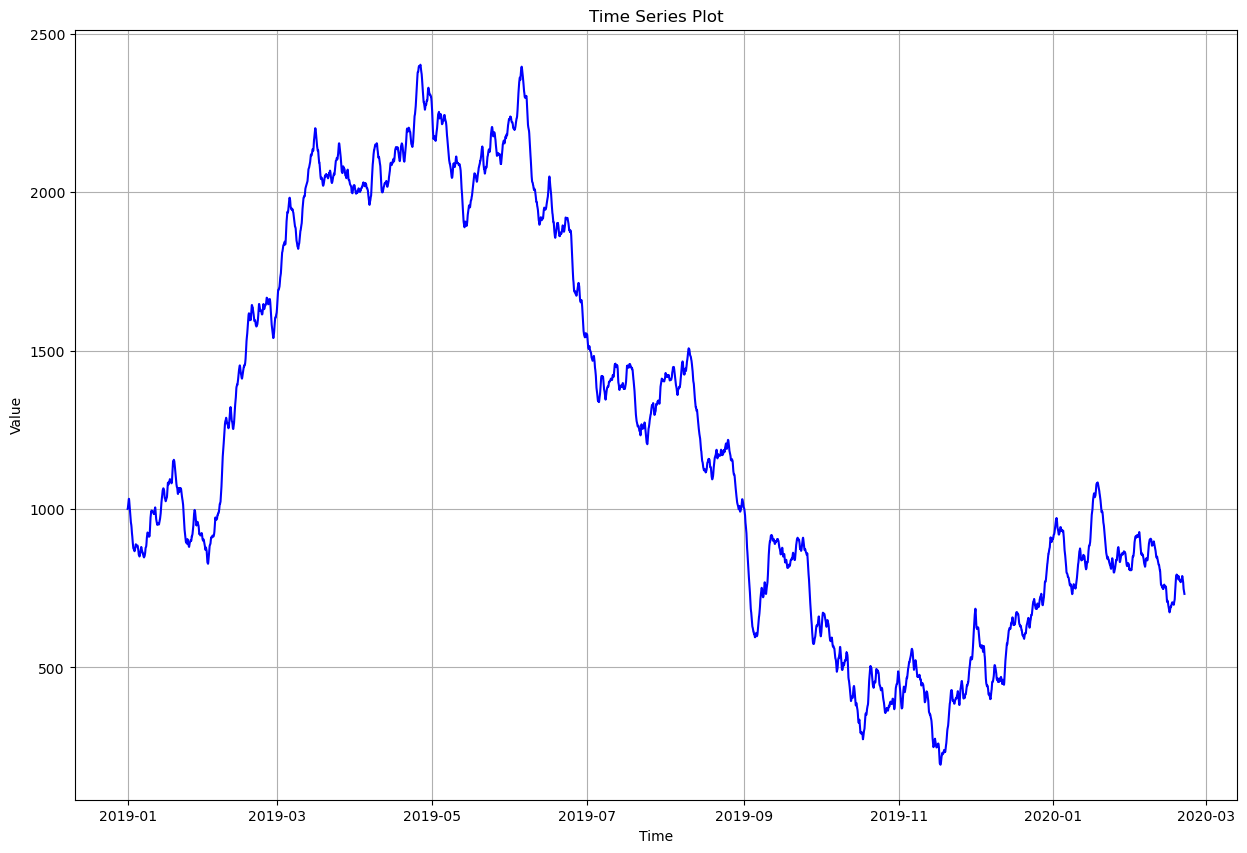

In [42]:
#ex2 - Visualize the time series.
#better to plot this time series

plt.figure(figsize=(15, 10))
plt.plot(df.index, df['hourly_bandwidth'], linestyle='-', color='b')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [43]:
#ex 3 - Verify if the time series is stationary.

# let's use the acrf to verify wether the time series is stationary

ADF_result = adfuller(df['hourly_bandwidth'])

print(f"ADF Statistic: {round(ADF_result[0], 3)}")
print(f"p-value: {round(ADF_result[1], 3)}")

if round(ADF_result[1], 3) < 0.05:
    print('Time Series is Stationary!')
else:
    print('Time Series is not Stationary!')


ADF Statistic: -0.871
p-value: 0.797
Time Series is not Stationary!


ADF Statistic: -23.799
p-value: 0.0
Time Series is Stationary!


<Figure size 1200x400 with 0 Axes>

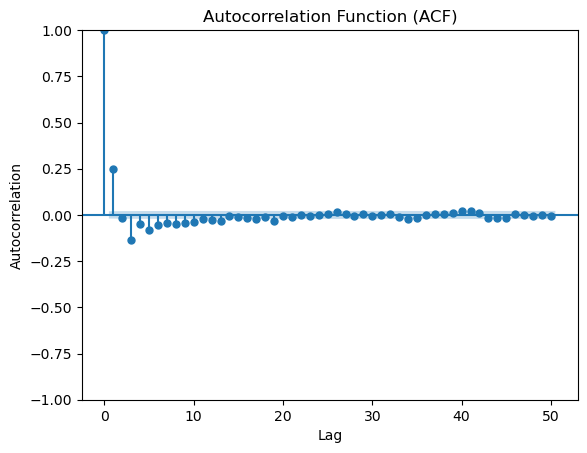

<Figure size 1200x400 with 0 Axes>

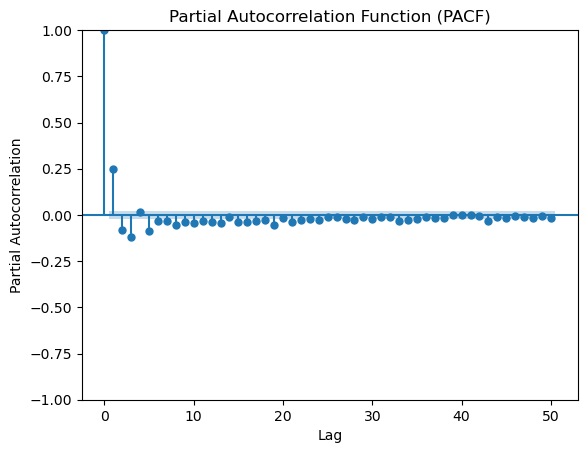

/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       hourly_bandwidth   No. Observations:                 9998
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -14562.937
Date:                Mon, 20 Nov 2023   AIC                          29131.874
Time:                        02:21:43   BIC                          29153.505
Sample:                    01-01-2019   HQIC                         29139.196
                         - 02-21-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.013     -0.012      0.990      -0.026       0.025
ma.L1          0.2459      0.010     25.360      0.000       0.227       0.265
sigma2         1.0782      0.015     71.504      0.0

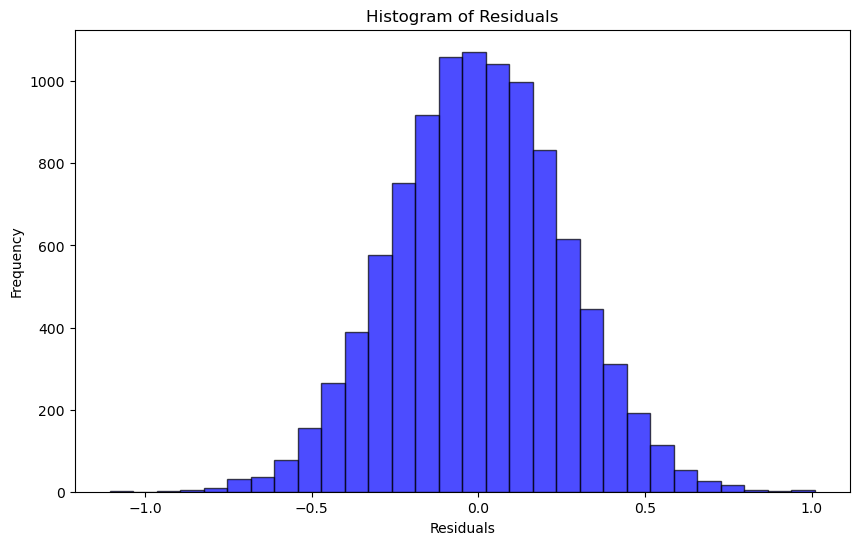

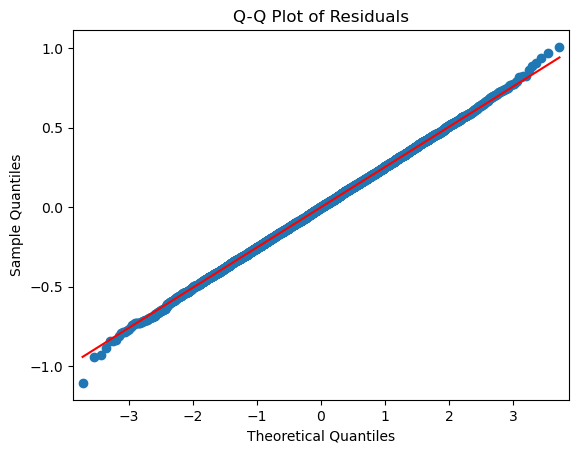

count    1.000000e+01
mean     3.669842e-02
std      7.881088e-02
min      5.191230e-59
25%      9.945025e-56
50%      3.202047e-53
75%      1.973796e-42
max      2.153468e-01
Name: lb_pvalue, dtype: float64

In [45]:
# ex4 - Based on your exploration, determine the most suitable model with the usual steps:
# a. Apply the transformations to make the time series stationary

#let's apply differencing



df['hourly_bandwidth'] = df['hourly_bandwidth'].diff() # this will reduce the number of elements by 1
df.dropna(inplace=True)

ADF_result = adfuller(df['hourly_bandwidth'])

print(f"ADF Statistic: {round(ADF_result[0], 3)}")
print(f"p-value: {round(ADF_result[1], 3)}")

if round(ADF_result[1], 3) < 0.05:
    print('Time Series is Stationary!')
else:
    print('Time Series is not Stationary!')


# b. Determine the adequate model to predict the series by plotting the autocorrelation and partial


# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(df['hourly_bandwidth'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(df['hourly_bandwidth'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


# Answer: the adequate model is ARMA(p, q)

# autocorrelation functions
# c. Find the optimal (p , q) parameters.


# stepwise_model = auto_arima(df['hourly_bandwidth'], seasonal=False, suppress_warnings=True, stepwise=True)
# print("Optimal (p, q) parameters:", stepwise_model.order)

#optimal values = 0, 1


# d. Fit the ARMA(p,q) model with the optimal parameters on the training set

p, q = 0, 1
arma_model = ARIMA(df['hourly_bandwidth'], order=(p, 0, q))  # Use order=(p, 0, q) for ARMA
arma_results = arma_model.fit()

# Print model summary
print(arma_results.summary())


# e. Perform the residual analysis to validate if the model can be used to forecast.

residuals = df['hourly_bandwidth'] - arma_results.resid


# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot of residuals
sm.qqplot(residuals, line='q')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Ljung-Box test on residuals
residuals_test = acorr_ljungbox(residuals, lags=10)

# Print the results
residuals_test['lb_pvalue'].describe()


Forecasted Bandwidth Usage for the Next Week:
2020-02-21 16:00:00    0.244117
2020-02-21 17:00:00   -0.000161
2020-02-21 18:00:00   -0.000161
2020-02-21 19:00:00   -0.000161
2020-02-21 20:00:00   -0.000161
2020-02-21 21:00:00   -0.000161
2020-02-21 22:00:00   -0.000161
Freq: H, Name: predicted_mean, dtype: float64


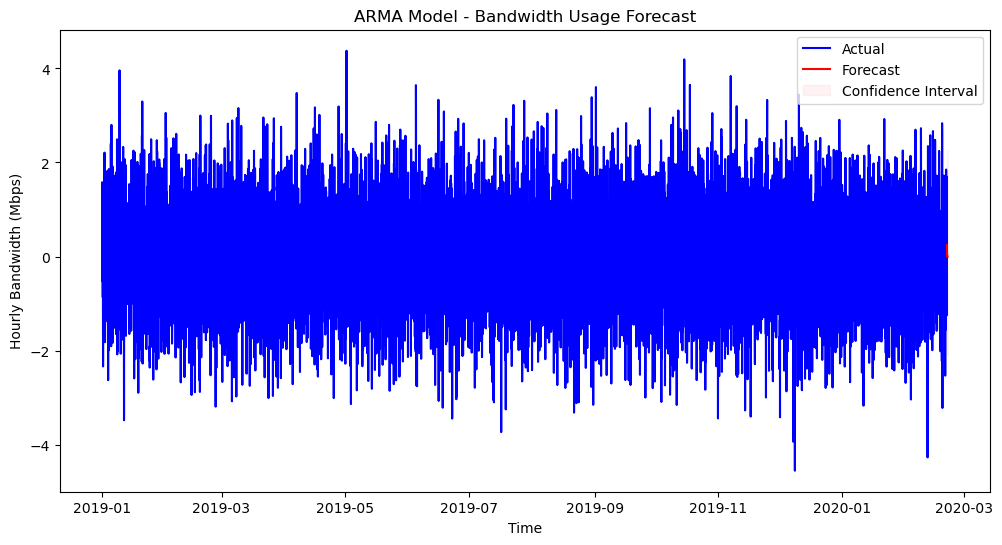

In [48]:
#ex5 - Predict a full week of the bandwidth usage using the last week of points as test set.

# Split the data into training and test sets
train_size = int(len(df) * 0.9)
train, test = df['hourly_bandwidth'][:train_size], df['hourly_bandwidth'][train_size:]



# Predict a full week (7 days) into the future
forecast_steps = 7
forecast = arma_results.get_forecast(steps=forecast_steps)

# Extract forecast values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Print the forecasted values
print("Forecasted Bandwidth Usage for the Next Week:")
print(forecast_values)

# Optionally, visualize the forecast along with the actual values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['hourly_bandwidth'], label='Actual', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.2, label='Confidence Interval')
plt.title('ARMA Model - Bandwidth Usage Forecast')
plt.xlabel('Time')
plt.ylabel('Hourly Bandwidth (Mbps)')
plt.legend()
plt.show()